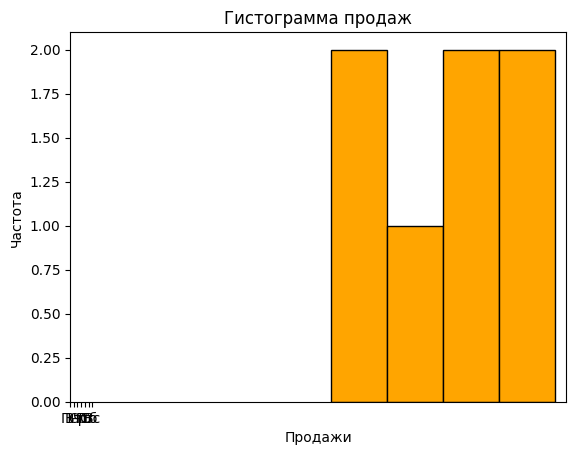

In [2]:
import matplotlib.pyplot as plt

дни_недели = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
продажи = [100, 120, 80, 90, 110, 70, 130]

plt.hist(продажи, bins='auto', edgecolor='black', color='orange')
plt.xlabel('Продажи')
plt.ylabel('Частота')
plt.title('Гистограмма продаж')
plt.xticks(range(len(дни_недели)), дни_недели)  # Установка подписей оси X
plt.show()


In [8]:
import numpy as np
import re
import random
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings
warnings.simplefilter(action='ignore')


In [9]:
df = pd.read_csv("vgsales.csv")

print(f'Size of dataset: {df.shape[0]}')

Size of dataset: 16598


In [10]:
# Определение колонок с пропусками
columns_with_null = df.columns[df.isnull().any()].tolist()
print("Колонки с пропусками:", columns_with_null)

print(df.info())

Колонки с пропусками: ['Year', 'Publisher']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None


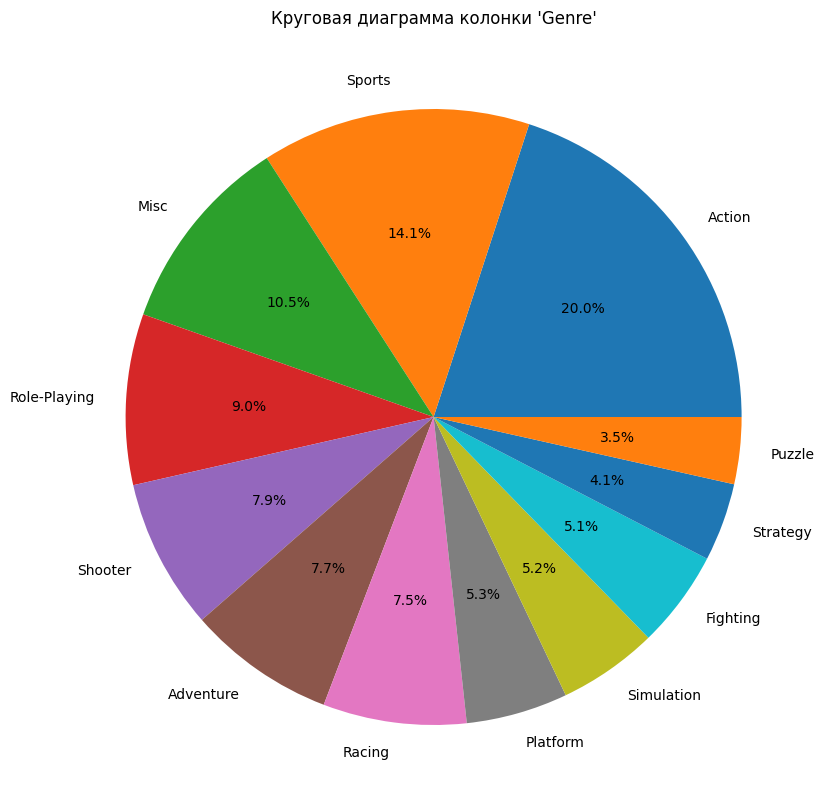

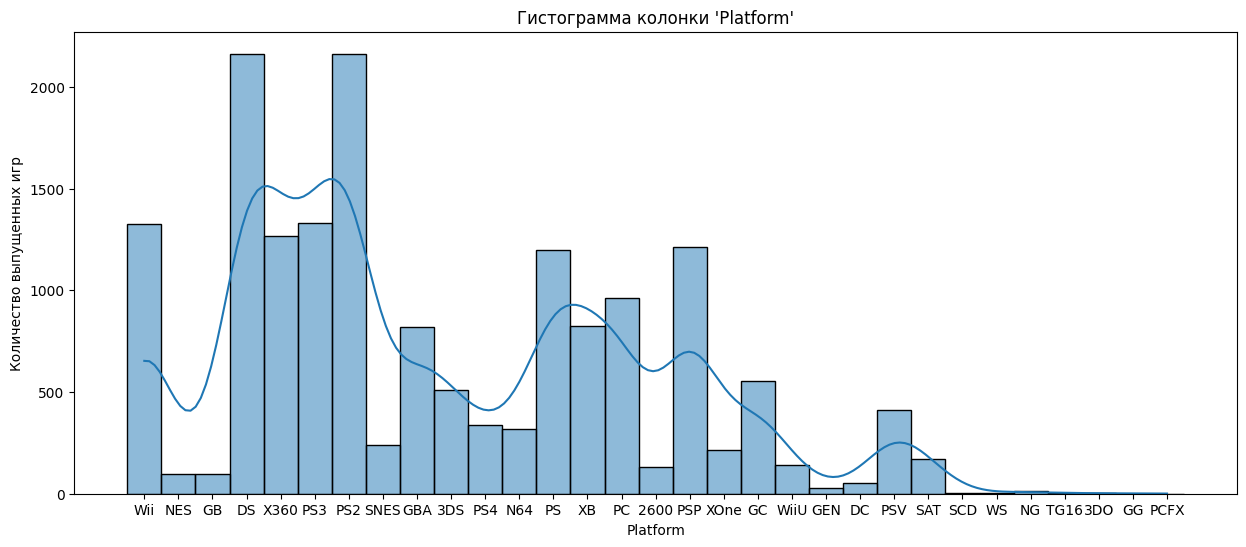

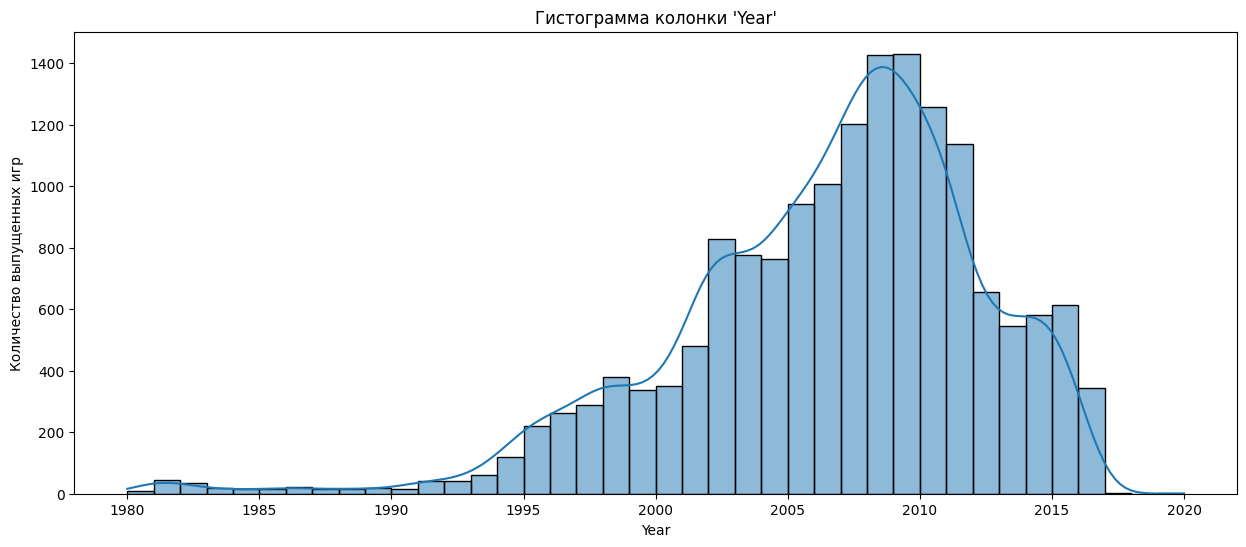

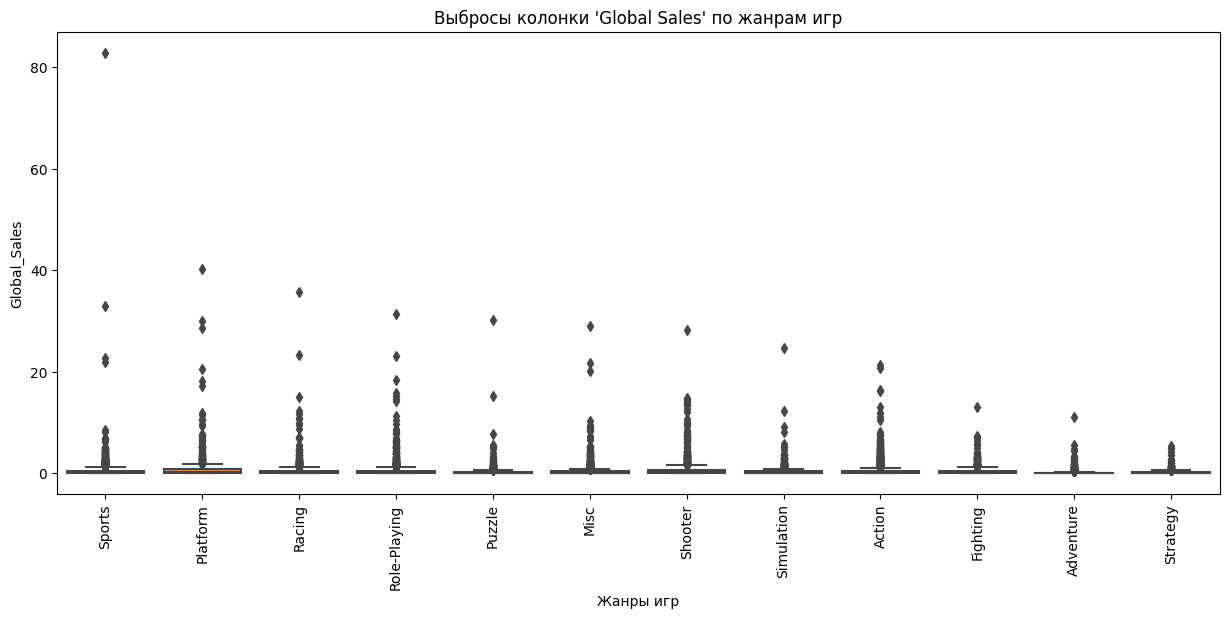

In [11]:
plt.figure(figsize=(10, 10))
# Получение уникальных значений и их количество
unique_values = df['Genre'].value_counts()
# Создание круговой диаграммы
plt.pie(unique_values, labels=unique_values.index, autopct='%1.1f%%')
plt.title(f"Круговая диаграмма колонки '{'Genre'}'")
plt.show()
for column in ['Platform', 'Year']:
    plt.figure(figsize=(15, 6))
    sns.histplot(data=df, x=column, kde=True, binwidth=1, bins=3)
    plt.title(f"Гистограмма колонки '{column}'")
    plt.ylabel('Количество выпущенных игр')
    plt.show()

# Визуализация классов (продаж)
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='Genre', y='Global_Sales')
plt.title("Выбросы колонки 'Global Sales' по жанрам игр")
plt.xticks(rotation=90)
plt.xlabel('Жанры игр')
plt.show()


In [12]:
print(df.isna().sum())

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


In [13]:
# Функция для заполнения года
year_of_support = {
    'Wii': [2006, 2013], 'NES': [1983, 1995], 'GB': [1989, 2003], 'DS': [2004, 2013],
    'X360': [2005, 2016], 'PS3': [2006, 2016], 'PS2': [2000, 2013], 'SNES': [1990, 1998],
    'GBA': [2001, 2006], '3DS': [2011, 2020], 'PS4': [2013, 2023], 'N64': [1996, 2002],
    'PS': [1994, 2000], 'XB': [2002, 2005], 'PC': [1985, 2023], '2600': [1977, 1984],
    'PSP': [2004, 2014], 'XOne': [2013, 2020], 'GC': [2001, 2007], 'WiiU': [2012, 2017],
    'GEN': [1988, 1997], 'DC': [1998, 2021], 'PSV': [2011, 2019], 'SAT': [1994, 1998],
    'SCD': [1991, 1996], 'WS': [1999, 2003], 'NG': [1990, 1997], 'TG16': [1987, 1993],
    '3DO': [1993, 1996], 'GG': [1990, 1997], 'PCFX': [1994, 1998]
}
# Был удивлен, но самая старая игра, согласно датасету на пк была выпущена в 1941 году, поэтому взял третье по "маленькости" - 1985


def fill_year(row):
    publisher = row["Publisher"]
    name = row["Name"]
    year = row["Year"]

    if publisher == "Electronic Arts" and pd.notnull(name):
        match = re.search(r"\d{4}", name)
        if match:
            extracted_year = int(match.group())
            new_year = extracted_year - 1
            return new_year

    platform = row["Platform"]
    if platform in year_of_support:
        platform_years = year_of_support[platform]
        random_year = random.randint(platform_years[0], platform_years[1])
        return random_year

    return year


# Заполнение пропущенных значений в столбце "Publisher"
df["Publisher"].fillna("Unknown", inplace=True)


# Применение функции к столбцу "Year"
df["Year"] = df.apply(fill_year, axis=1)

# Создаем копию датасета
df_agg = df.copy()

# Определяем пороговое значение для определения редких значений
threshold = 200

# Получаем список редких значений
rare_publishers = df_agg['Publisher'].value_counts()[df_agg['Publisher'].value_counts() < threshold].index

# Заменяем редкие значения на 'Other'
df_agg.loc[df_agg['Publisher'].isin(rare_publishers), 'Publisher'] = 'Other'

# Проверяем результаты
# print(df_agg['Publisher'].value_counts())

platform_ranges = {
    'Nintendo': ['Wii', 'NES', 'GB', 'DS', 'SNES', 'GBA', '3DS', 'N64', 'GC', 'WiiU'],
    'Sony': ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV'],
    'Microsoft': ['XB', 'X360', 'XOne'],
    'PC': ['PC'],
    'Other': ['2600', 'GEN', 'DC', 'SAT', 'SCD', 'WS', 'NG', 'TG16', '3DO', 'GG', 'PCFX']
}


def get_platform_family(platform):
    for platform_type, platforms in platform_ranges.items():
        if platform in platforms:
            return platform_type


# Применяем функцию к столбцу "Platform" и создаем новый столбец "Platform_Type"
df_agg['Platform_Family'] = df_agg['Platform'].apply(get_platform_family)
dummy_df = pd.get_dummies(df_agg['Platform_Family'])

In [14]:
result=pd.concat([df_agg, dummy_df], axis=1)

In [15]:
print(result.isna().sum())

Rank               0
Name               0
Platform           0
Year               0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Platform_Family    0
Microsoft          0
Nintendo           0
Other              0
PC                 0
Sony               0
dtype: int64


In [16]:
# Создаем экземпляр класса LabelEncoder
label_encoder = LabelEncoder()

# Применяем Label Encoding к столбцу Genre
result['Genre_encoded'] = label_encoder.fit_transform(result['Genre'])

# Применяем Label Encoding к столбцу Publisher
result['Publisher_encoded'] = label_encoder.fit_transform(result['Publisher'])


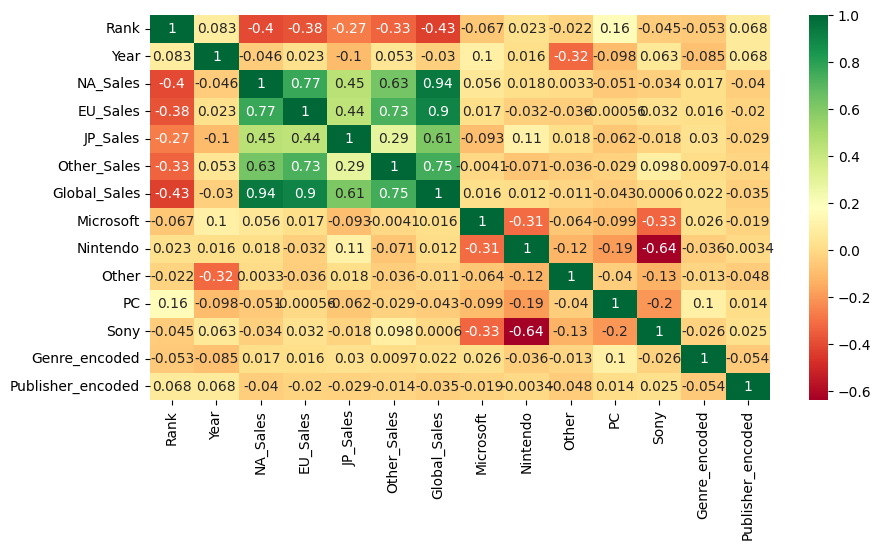

In [17]:
# вычислим матрицу корреляции
corr_matrix = result.corr()

plt.subplots(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn")
plt.show()


In [18]:
result = result.drop(['NA_Sales', 'JP_Sales', 'Other_Sales', 'EU_Sales'], axis=1)

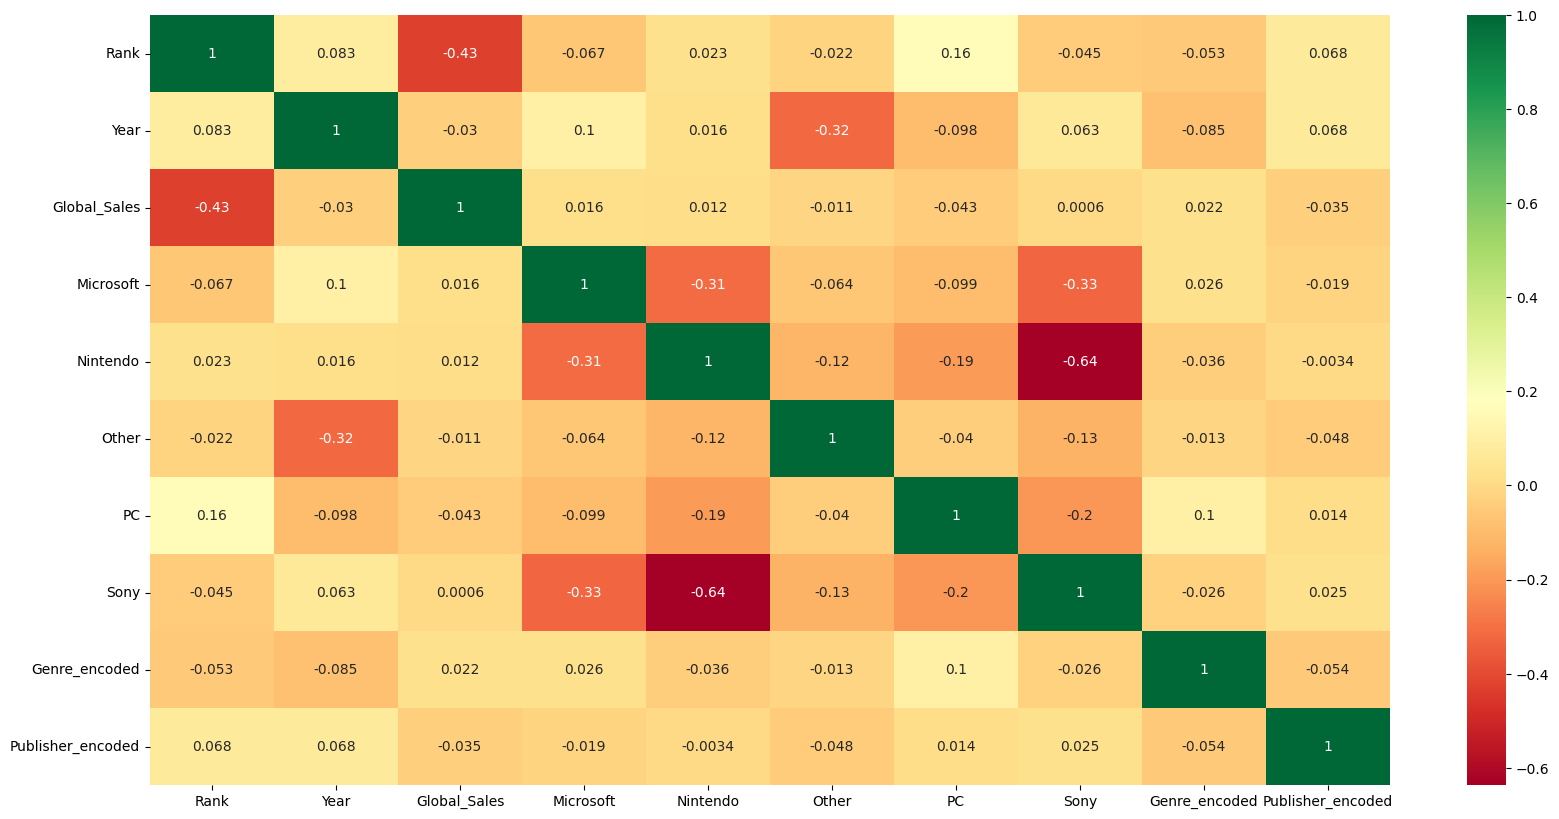

In [19]:
# вычислим матрицу корреляции
corr_matrix = result.corr()

plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn")
plt.show()


In [20]:
metrics = {
    'svm': {'mse': [], 'mae': [], 'rmse': [], 'r2': []},
    'rf': {'mse': [], 'mae': [], 'rmse': [], 'r2': []},
}


def update_metric(svr, rf, metrics, y_test):
    metrics['svm']['mse'].append(mean_squared_error(y_test, svr))
    metrics['rf']['mse'].append(mean_squared_error(y_test, rf))

    metrics['svm']['rmse'].append(sqrt(mean_squared_error(y_test, svr)))
    metrics['rf']['rmse'].append(sqrt(mean_squared_error(y_test, rf)))

    metrics['svm']['mae'].append(mean_absolute_error(y_test, svr))
    metrics['rf']['mae'].append(mean_absolute_error(y_test, rf))

    metrics['svm']['r2'].append(r2_score(y_test, svr))
    metrics['rf']['r2'].append(r2_score(y_test, rf))


In [21]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = result[['Rank', 'Year', 'Microsoft', 'Nintendo', 'Other',
            'PC', 'Sony', 'Genre_encoded', 'Publisher_encoded']]
y = result['Global_Sales']

# Создание экземпляра класса KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

time_svm = 0
time_rf = 0
# Итерация по разбиениям и обучение моделей
for train_index, test_index in kfold.split(X, y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Обучение модели SVM
    svm = SVR()
    start = time.time()
    svm.fit(X_train, y_train)
    end = time.time()
    time_svm += (end-start)
    svm_pred = svm.predict(X_test)

    # Обучение модели Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    end = time.time()
    time_rf += (end-start)
    rf_pred = rf.predict(X_test)

    update_metric(svm_pred, rf_pred, metrics, y_test)


KeyboardInterrupt: 

In [ ]:
print(time_rf)
print(time_svm)

18.112491130828857
6.2984254360198975


In [ ]:
metrics_lower = ['MSE', 'MAE', 'RMSE','R2 score','Adjusted R-squared']
def mean_of_list(data):
    return sum(data)/len(data)

n = X.shape[0]
p = X.shape[1]

def adj_r2(r2):
    res = 1- (1-r2)*(n-1)/(n-p-1)
    return res

data1 = []
data2 = []

for key in metrics['rf'].keys():
    data1.append(mean_of_list(metrics['rf'][key]))
    data2.append(mean_of_list(metrics['svm'][key]))

data1.append(adj_r2(data1[2]))
data2.append(adj_r2(data2[2]))

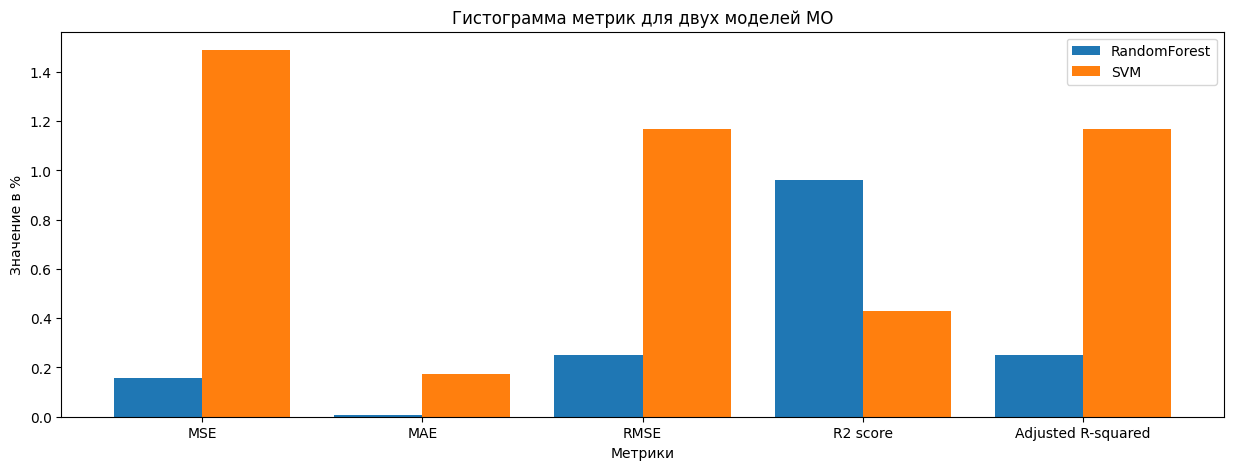

In [ ]:
# Ширина каждого столбца
width = 0.4

# Положение столбцов на оси x
x_pos = range(len(data1))

# Создание подграфика
fig, ax= plt.subplots(1,1, figsize=(15,5))

# Построение гистограммы для первого набора данных
ax.bar(x_pos, data1, width=width, align='edge', label='RandomForest')

# Построение гистограммы для второго набора данных
ax.bar([p + width for p in x_pos], data2, width=width, align='edge', label='SVM')

# Настройка осей и заголовка
ax.set_ylabel('Значение в %')
ax.set_xlabel('Метрики')
ax.set_title('Гистограмма метрик для двух моделей МО')
ax.set_xticks([p + width for p in x_pos])
ax.set_xticklabels(metrics_lower)

# Добавление легенды
ax.legend()
plt.show()

In [ ]:
print(data1)
mean_metric = 0
mean_metric1 = 0
for i in range(len(data1)):
    if i != 3:
        mean_metric += data1[i]
        mean_metric1 += data2[i]

print(mean_metric/(len(data1)-1))
print(mean_metric1/(len(data1)-1))
print(data1[3])
print(data2[3])

[0.15547914285689501, 0.006222974872675706, 0.25158192361098564, 0.9600611425215476, 0.25117586123532243]
0.1661149756439697
0.9992042708953242
0.9600611425215476
0.43080882519010144
